In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


# Market Basket Analysis

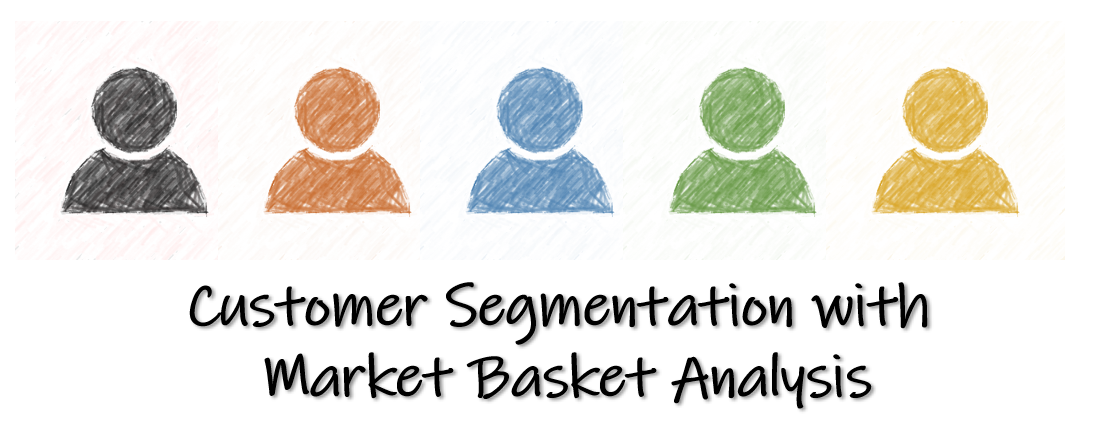

**Import libraries**

In [2]:
import pandas as pd
import pandas_profiling as pp
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import networkx as nx

In [3]:
import warnings
warnings.filterwarnings("ignore")

**Import data**

In [4]:
dat = pd.read_csv("../input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")

**Exploratory data analysis (EDA)**

In [5]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
dat.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

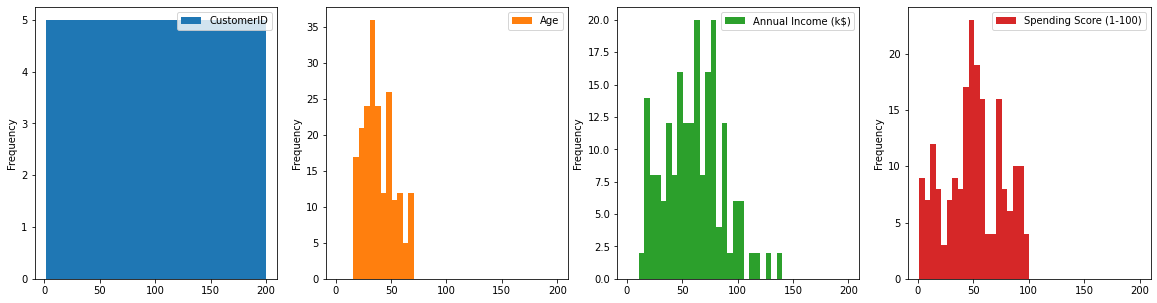

In [7]:
fig,ax = plt.subplots(1,4,figsize=(20,5))
dat.plot(kind='hist',ax=ax, subplots=True, bins=40)

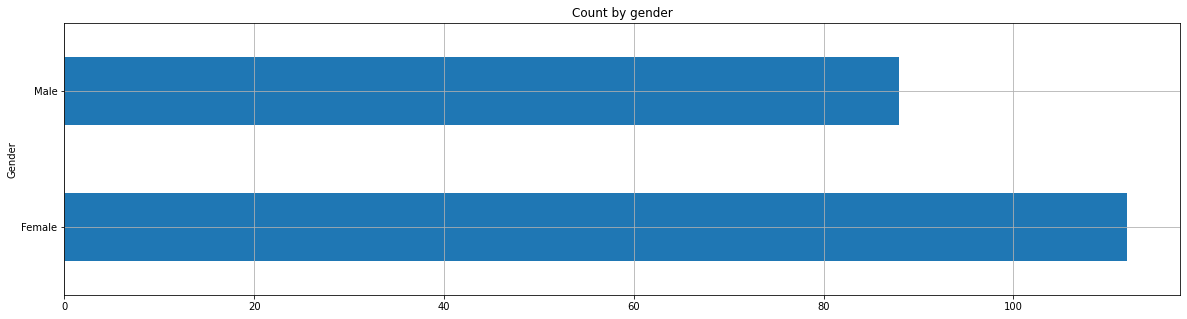

In [8]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
dat.groupby("Gender").CustomerID.agg('count').plot(kind='barh',ax=ax).set_title('Count by gender')
plt.grid()

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

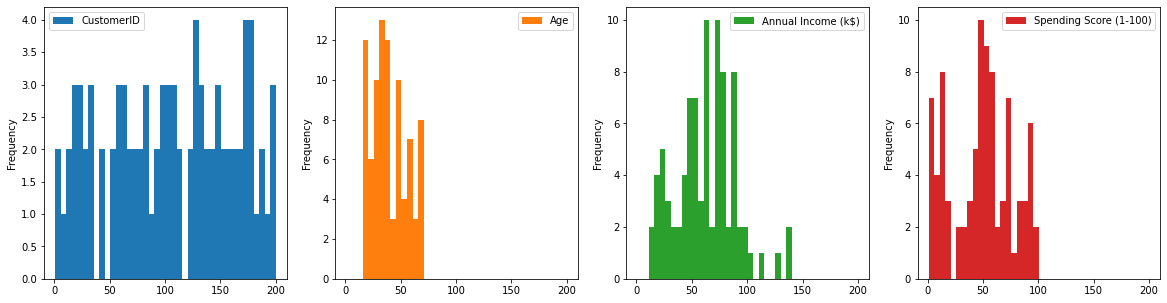

In [9]:
fig,ax = plt.subplots(1,4,figsize=(20, 5))
sdat = dat.groupby(by='Gender')
sdat.get_group("Male").plot(kind='hist',ax=ax, subplots=True, bins=40)

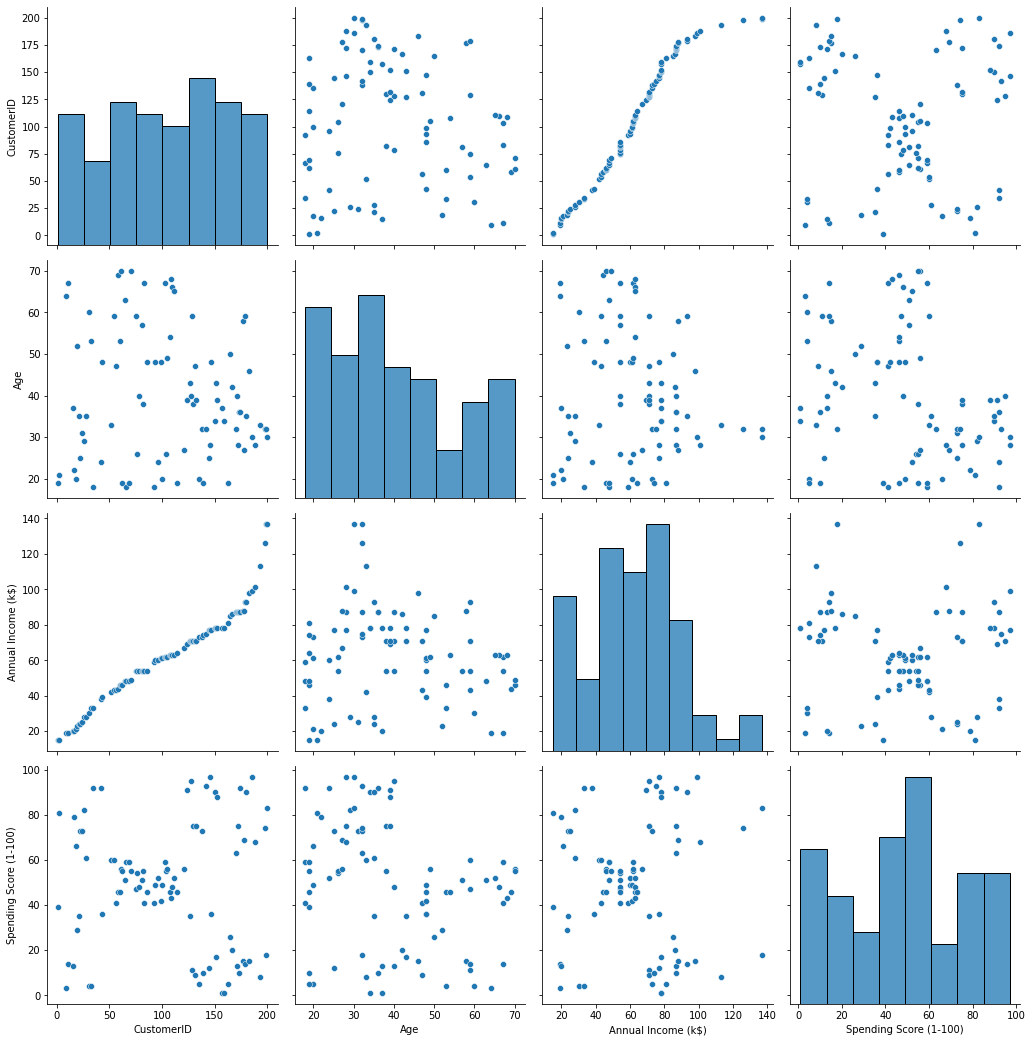

In [10]:
sns.pairplot(sdat.get_group("Male")).fig.set_size_inches(15,15)

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

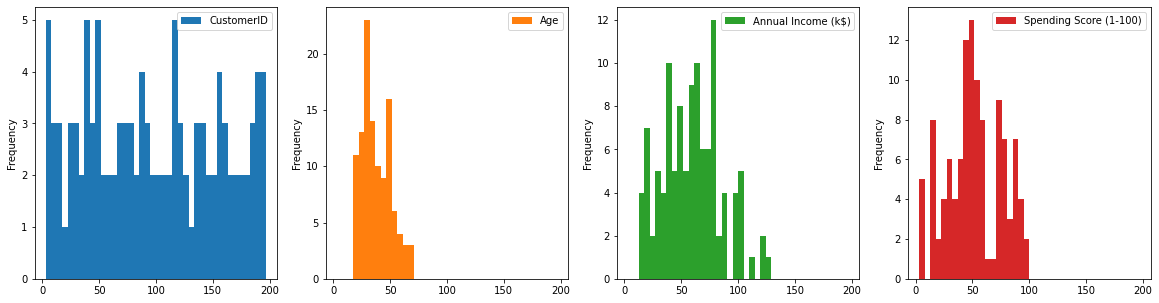

In [11]:
fig,ax = plt.subplots(1,4,figsize=(20, 5))
sdat = dat.groupby(by='Gender')
sdat.get_group("Female").plot(kind='hist',ax=ax, subplots=True, bins=40)

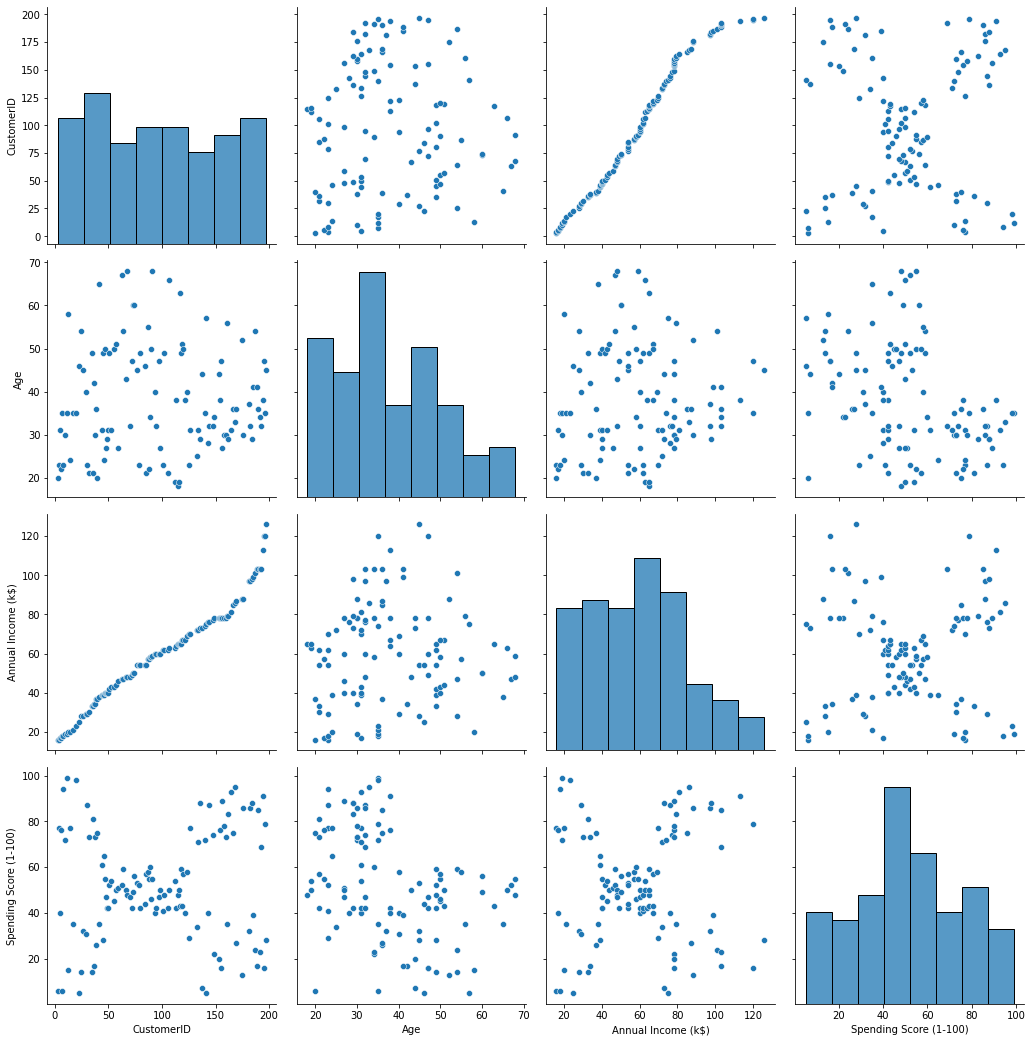

In [12]:
sns.pairplot(sdat.get_group("Female")).fig.set_size_inches(15,15)

<AxesSubplot:>

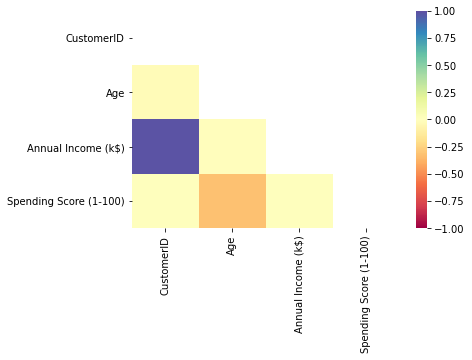

In [13]:
mask = np.triu(np.ones_like(dat.corr(), dtype=bool))
sns.heatmap(dat.corr(),mask=mask,cmap='Spectral',vmin=-1,vmax=1)

In [14]:
dat.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

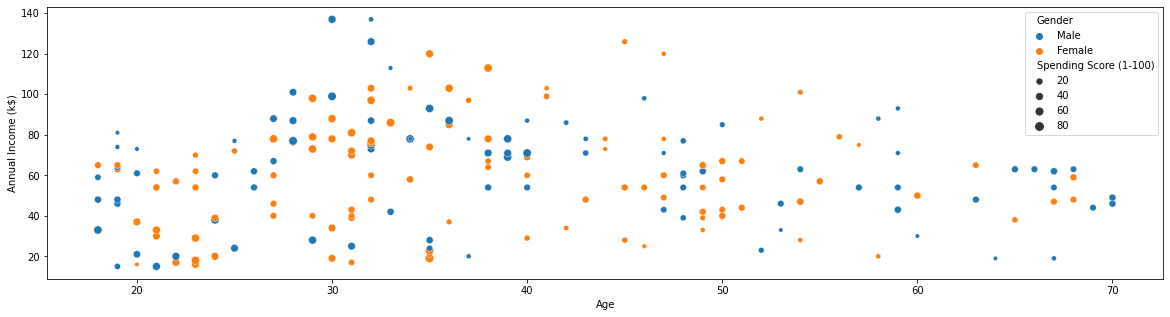

In [15]:
sns.scatterplot(data=dat,x='Age',y='Annual Income (k$)',hue='Gender',size='Spending Score (1-100)')
fig = plt.gcf()
fig.set_size_inches(20,5)

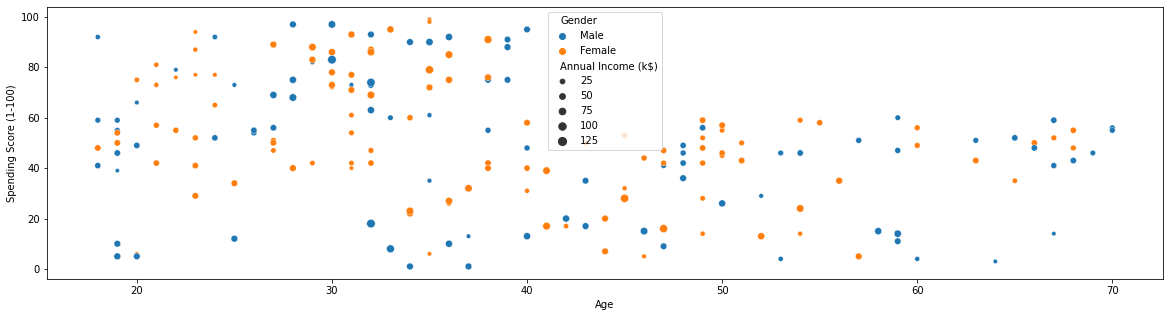

In [16]:
sns.scatterplot(data=dat,x='Age',size='Annual Income (k$)',hue='Gender',y='Spending Score (1-100)')
fig = plt.gcf()
fig.set_size_inches(20,5)

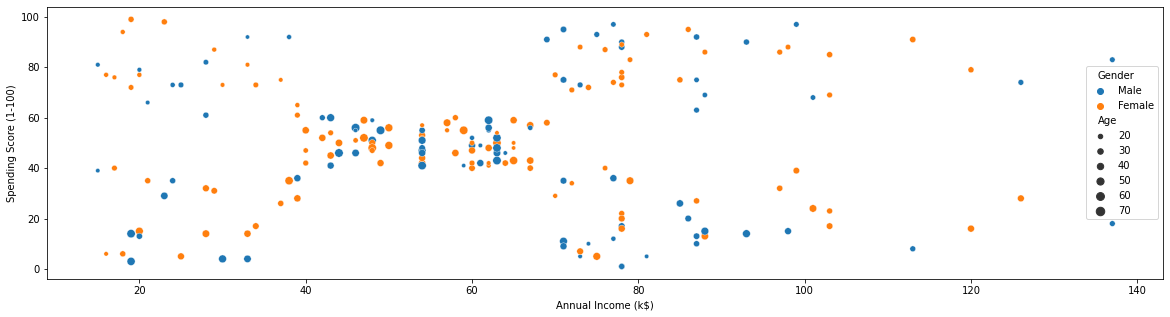

In [17]:
sns.scatterplot(data=dat,size='Age',x='Annual Income (k$)',hue='Gender',y='Spending Score (1-100)')
fig = plt.gcf()
fig.set_size_inches(20,5)

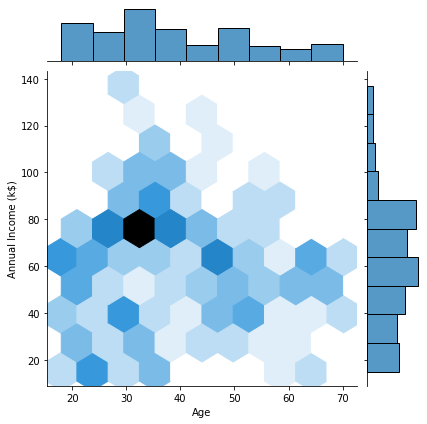

In [18]:
sns.jointplot(x=dat.Age, y=dat['Annual Income (k$)'],kind='hex')
fig = plt.gcf()
fig.set_size_inches(6,6)

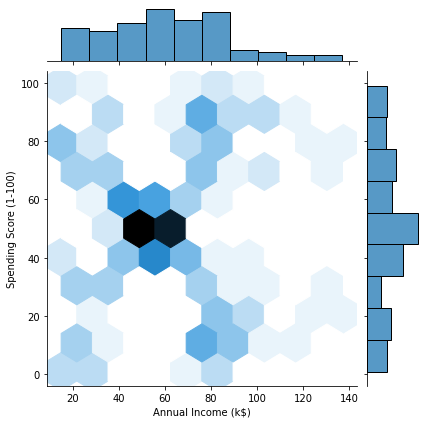

In [19]:
sns.jointplot(x=dat['Annual Income (k$)'],y = dat['Spending Score (1-100)'],kind='hex')
fig = plt.gcf()
fig.set_size_inches(6,6)

In [20]:
# pp.ProfileReport(dat)

**Scale the data**

In [21]:
df = dat.copy()
df.drop(axis=1,columns='CustomerID',inplace=True)
df['IsMale'] = 1
df.loc[df[df.Gender == "Female"].index,'IsMale'] = 0
df.drop(axis=1, columns='Gender',inplace=True)
df.head()

,Age,Annual Income (k$),Spending Score (1-100),IsMale
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


In [22]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100),IsMale
count,200.000000,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000,0.440000
std,13.969007,26.264721,25.823522,0.497633
min,18.000000,15.000000,1.000000,0.000000
25%,28.750000,41.500000,34.750000,0.000000
50%,36.000000,61.500000,50.000000,0.000000
75%,49.000000,78.000000,73.000000,1.000000
max,70.000000,137.000000,99.000000,1.000000


In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [24]:
scal = MinMaxScaler()
temp = scal.fit_transform(df)
dfscal = pd.DataFrame(temp,columns=df.columns, index=df.index)
dfscal.head()

,Age,Annual Income (k$),Spending Score (1-100),IsMale
0,0.019231,0.000000,0.387755,1.0
1,0.057692,0.000000,0.816327,1.0
2,0.038462,0.008197,0.051020,0.0
3,0.096154,0.008197,0.775510,0.0
4,0.250000,0.016393,0.397959,0.0


**Clustering**

In [25]:
cdf = dfscal.copy()

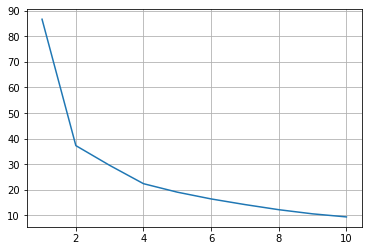

In [26]:
inertia = []
for icluster in range(1,11):
    clust = KMeans(n_clusters=icluster, n_init=10, max_iter=300, tol=1e-3, random_state=0)
    clust.fit(cdf)
    inertia.append(clust.inertia_)
    
sns.lineplot(x=range(1,11), y=inertia)
plt.grid()

# optimal number of clusters with approximate slope 135 degrees, n = 5

In [27]:
clust = KMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-3, random_state=0)
clust.fit(cdf)
cdf['Labels_'] = clust.labels_
centroids = clust.cluster_centers_

In [28]:
dfscal.head()

,Age,Annual Income (k$),Spending Score (1-100),IsMale
0,0.019231,0.000000,0.387755,1.0
1,0.057692,0.000000,0.816327,1.0
2,0.038462,0.008197,0.051020,0.0
3,0.096154,0.008197,0.775510,0.0
4,0.250000,0.016393,0.397959,0.0


In [29]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100),IsMale
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


In [30]:
cdf.head()

,Age,Annual Income (k$),Spending Score (1-100),IsMale,Labels_
0,0.019231,0.000000,0.387755,1.0,3
1,0.057692,0.000000,0.816327,1.0,3
2,0.038462,0.008197,0.051020,0.0,2
3,0.096154,0.008197,0.775510,0.0,1
4,0.250000,0.016393,0.397959,0.0,1


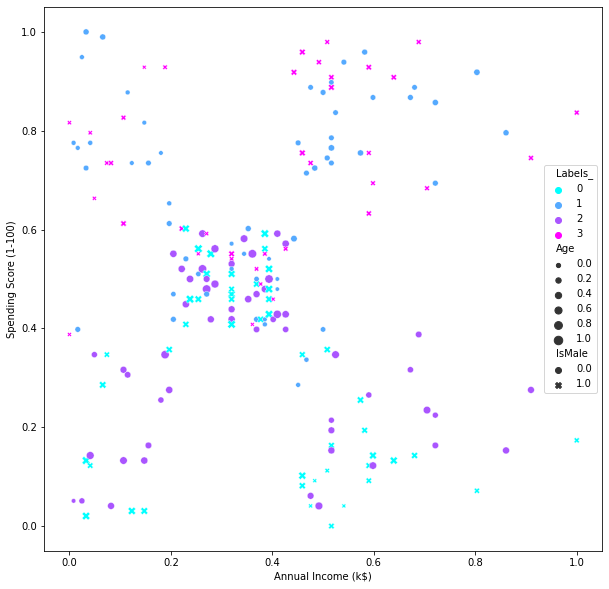

In [31]:
import matplotlib as mp
cmap = mp.cm.cool
sns.scatterplot(data=cdf,size='Age',x='Annual Income (k$)',hue='Labels_',y='Spending Score (1-100)',style='IsMale',palette=cmap)
fig = plt.gcf()
fig.set_size_inches(10,10)

In [32]:
np.random.seed(0)

In [33]:
def jitter(x):
    if x < 0.5:
        x = x + np.random.random()*0.45
    else:
        x = x - np.random.random()*0.45
    return x
            
cdf['JitterIsMale'] = cdf['IsMale']
cdf['JitterIsMale'] = cdf['JitterIsMale'].apply(jitter)

In [34]:
def bin_column(x):
    # note that this assumes scaled columns
    nbin = 4
    bd = np.linspace(0,1,nbin+1)
    for i, nbd in enumerate(bd):
        if x < nbd:
            return i
            
cdf['BinIncome'] = cdf['Annual Income (k$)'].apply(bin_column)

In [35]:
cdf.sample(10)

,Age,Annual Income (k$),Spending Score (1-100),IsMale,Labels_,JitterIsMale,BinIncome
90,0.961538,0.360656,0.551020,0.0,2,0.143356,2.0
97,0.173077,0.368852,0.500000,0.0,1,0.009048,2.0
2,0.038462,0.008197,0.051020,0.0,2,0.271244,1.0
150,0.480769,0.516393,0.163265,1.0,0,0.932748,3.0
77,0.423077,0.319672,0.479592,1.0,0,0.945912,2.0
15,0.076923,0.040984,0.795918,1.0,3,0.960792,1.0
109,0.923077,0.393443,0.479592,1.0,0,0.571263,2.0
11,0.326923,0.032787,1.000000,0.0,1,0.238003,1.0
159,0.230769,0.516393,0.734694,0.0,1,0.031125,3.0
153,0.384615,0.516393,0.765306,0.0,1,0.277002,3.0


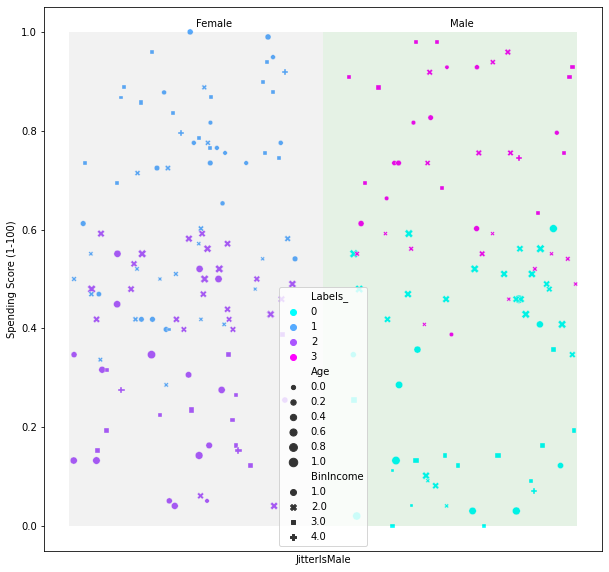

In [36]:
sns.scatterplot(data=cdf,size='Age',x='JitterIsMale',hue='Labels_',y='Spending Score (1-100)',style='BinIncome',palette=cmap)
fig = plt.gcf()
fig.set_size_inches(10,10)
fig.axes[0].add_patch(mp.patches.Rectangle((0,0),0.5,1,fill=True,facecolor='gray',alpha=0.1))
fig.axes[0].add_patch(mp.patches.Rectangle((0.5,0),0.5,1,fill=True,facecolor='green',alpha=0.1))
plt.text(0.25,1.01,"Female")
plt.text(0.75,1.01,"Male")
plt.gca().set_xticks([])
plt.legend()
plt.show()

**Dimension reduction**

In [37]:
from sklearn.decomposition import PCA

In [38]:
cdf.columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'IsMale',
       'Labels_', 'JitterIsMale', 'BinIncome'],
      dtype='object')

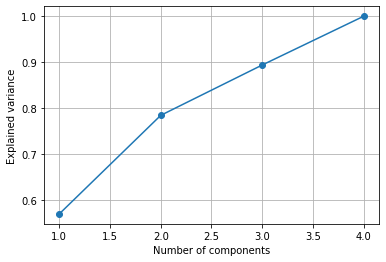

In [39]:
dimred_df = cdf.copy()
dimred_df.drop(columns=['Labels_', 'JitterIsMale', 'BinIncome'], inplace=True)
pca = PCA(n_components=4)
pca.fit_transform(dimred_df)
plt.plot(np.arange(1,5),np.cumsum(pca.explained_variance_ratio_),'o-')
plt.ylabel("Explained variance")
plt.xlabel("Number of components")
plt.grid()

In [40]:
dimred_df.sample(5)

,Age,Annual Income (k$),Spending Score (1-100),IsMale
149,0.307692,0.516393,0.908163,1.0
147,0.269231,0.508197,0.744898,0.0
192,0.288462,0.803279,0.071429,1.0
131,0.403846,0.459016,0.755102,1.0
136,0.500000,0.475410,0.061224,0.0


In [41]:
pca = PCA(n_components=4)
pca_dat = pca.fit_transform(dimred_df)

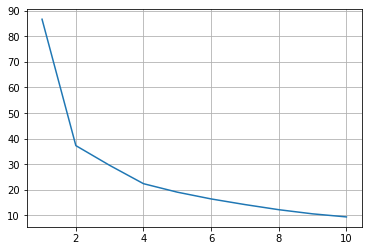

In [42]:
pca_inertia = []
for icluster in range(1,11):
    clust = KMeans(n_clusters=icluster, n_init=10, max_iter=300, tol=1e-3, random_state=0)
    clust.fit(pca_dat)
    pca_inertia.append(clust.inertia_)
    
sns.lineplot(x=range(1,11), y=pca_inertia)
plt.grid()

In [43]:
clust = KMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-3, random_state=0)
clust.fit(pca_dat)
pca_df = pd.DataFrame(pca_dat, index=df.index, columns=['Comp1','Comp2','Comp3','Comp4'])
pca_df['Labels_'] = clust.labels_

In [44]:
pca_df.head()

,Comp1,Comp2,Comp3,Comp4,Labels_
0,0.532955,-0.227841,0.321860,-0.415081,3
1,0.513939,-0.493080,-0.016202,-0.402672,3
2,-0.446266,0.087079,0.555761,-0.382392,2
3,-0.478796,-0.366617,-0.010714,-0.361842,1
4,-0.451984,0.003006,0.159208,-0.353639,1


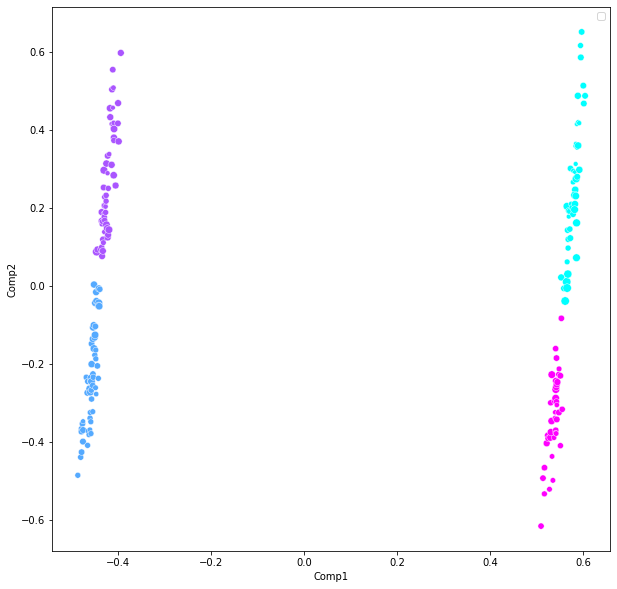

In [45]:
sns.scatterplot(data=pca_df,size='Comp3',x='Comp1',hue='Labels_',y='Comp2',palette=cmap)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.legend('')

Based on the analysis, Gender and spending score is sufficent for clustering.

**Testing hypothesis**

In [46]:
test_df = cdf.copy()
test_df.drop(inplace=True,columns=['Age', 'Annual Income (k$)', 'Labels_', 'JitterIsMale', 'BinIncome'])
clust = KMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-3, random_state=0)

clust.fit(test_df)
test_df['Labels_'] = clust.labels_

In [47]:
test_df.sample(5)

,Spending Score (1-100),IsMale,Labels_
143,0.877551,0.0,0
144,0.112245,1.0,3
182,0.142857,1.0,3
65,0.591837,1.0,1
49,0.418367,0.0,2


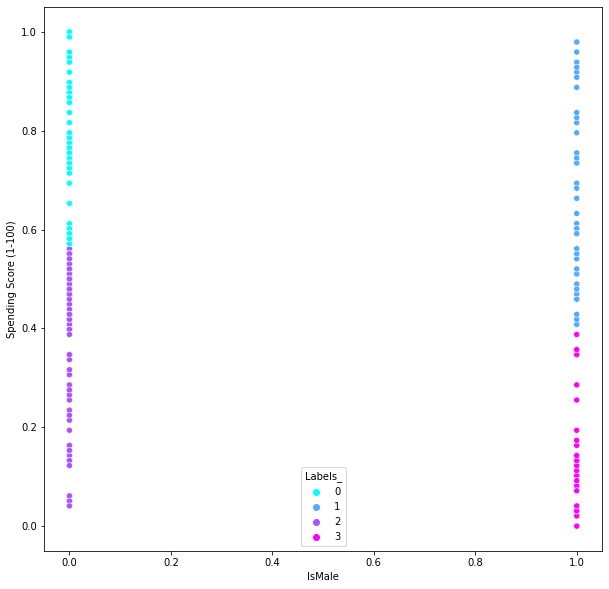

In [48]:
sns.scatterplot(data=test_df,y='Spending Score (1-100)',hue='Labels_',x='IsMale',palette=cmap)
fig = plt.gcf()
fig.set_size_inches(10,10)